In [1]:
import time
import multiprocessing
import psutil
psutil.cpu_percent(interval=1.0)
import tensorflow as tf
import dataloaders
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = "retina"
from tqdm import trange
import ops

n_cores = multiprocessing.cpu_count()
worker_threads = n_cores - 12
tf.config.threading.set_inter_op_parallelism_threads(n_cores)

IMG_SIZE = 224
BATCH_SIZE = 1024
ITERATIONS = 100
L_IMG_SIZE = int(IMG_SIZE*1.1)

tf_image_dtype = tf.float32

## Naive Example

In [2]:
dataset = dataloaders.return_naive_tfds(dataset_name="imagenet2012",
                                        data_dir="/raid/tensorflow_datasets",
                                        buffer=16384)
num_class = dataset["num_class"]

@tf.function
def read_example(image, label):
    image = ops.resize_preserve_ratio(image, L_IMG_SIZE)
    image = ops.augment_image(image, IMG_SIZE)
    return image, label

train = dataset["train"]
train = train.map(read_example, num_parallel_calls=worker_threads)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(8)
train_iter = iter(train)

print("Running pipeline:")
batch = next(train_iter)
image, label = batch[0].numpy(), batch[1].numpy()
print("* Image shape:", image.shape)
print("* Label shape:", label.shape)

print("Wait for CPU idle")
while psutil.cpu_percent(interval=1.0) > 1/n_cores*100:
    time.sleep(1)
print("CPU:", psutil.cpu_percent(interval=None))
print("Done!")

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imagenet2012 (/raid/tensorflow_datasets/imagenet2012/5.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /raid/tensorflow_datasets/imagenet2012/5.0.0


Found 1000 classes in imagenet2012
Found training examples: 1281167
Found validation examples: 50000
Train output: <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Valid output: <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Took 9 seconds to return dataset
Running pipeline:
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024,)
Wait for CPU idle
CPU: 33.3
Done!


Measure overhead: 0.19147109985351562 s


100%|██████████| 101/101 [01:36<00:00,  1.05it/s]


Total time taken: 96.18734979629517
   Images/second: 1064


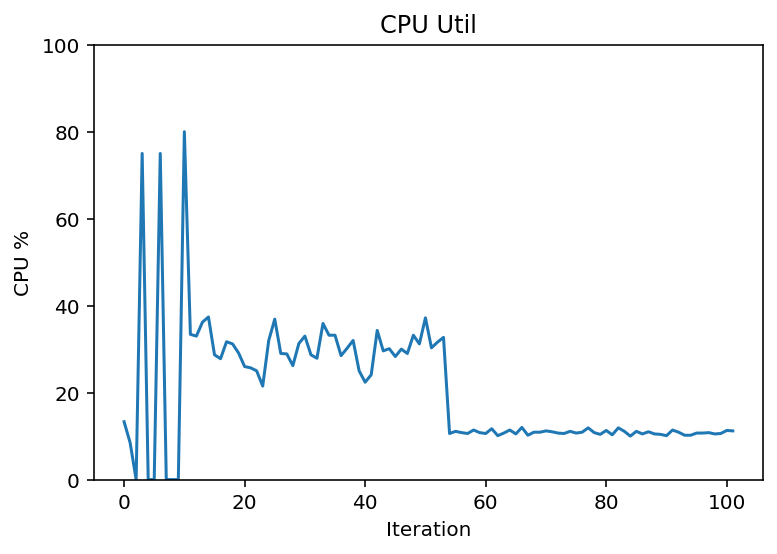

In [3]:
cpu_util = []

print("Measure overhead: ", end="")

st = time.time()
for i in range(1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()
overhead = et-st

print(overhead, "s")

time.sleep(2)

st = time.time()
for i in trange(ITERATIONS+1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()

duration = et-st-overhead
fps = int(BATCH_SIZE*ITERATIONS/duration)
iter_duration = duration/ITERATIONS
print("Total time taken:", duration)
print("   Images/second:", fps)

x = list(range(len(cpu_util)))
plt.title("CPU Util")
plt.plot(x, cpu_util)
plt.xlabel("Iteration")
plt.ylabel("CPU %")
plt.ylim((0,100))
plt.show()

In [4]:
# clean-up
del dataset, train, read_example
time.sleep(1)
tf.keras.backend.clear_session()

## Fast Example

In [10]:
dataset = dataloaders.return_fast_tfds(dataset_name="imagenet2012",
                                       data_dir="/raid/tensorflow_datasets",
                                       worker_threads=worker_threads,
                                       buffer=16384)
num_class = dataset["num_class"]

optionals = tf.autograph.experimental.Feature.ALL
@tf.function#(experimental_autograph_options=optionals)
def read_example(image_path, label):
    image = tf.io.decode_jpeg(image_path, channels=3, ratio=1,
                              fancy_upscaling=False,
                              dct_method="INTEGER_FAST")
    image = ops.resize_preserve_ratio(image, L_IMG_SIZE)
    image = ops.augment_image(image, IMG_SIZE)
    return image, label

train = dataset["train"]
train = train.map(read_example, num_parallel_calls=worker_threads)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(8)
train_iter = iter(train)

print("Running pipeline:")
batch = next(train_iter)
image, label = batch[0].numpy(), batch[1].numpy()
print("* Image shape:", image.shape)
print("* Label shape:", label.shape)

print("Wait for CPU idle")
while psutil.cpu_percent(interval=1.0) > 1/n_cores*100:
    time.sleep(1)
print("CPU:", psutil.cpu_percent(interval=None))
print("Done!")

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imagenet2012 (/raid/tensorflow_datasets/imagenet2012/5.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /raid/tensorflow_datasets/imagenet2012/5.0.0


Found 1000 classes in imagenet2012
Found training examples: 1281167
Found validation examples: 50000
Train output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Valid output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Took 0 seconds to return dataset
Running pipeline:
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024,)
Wait for CPU idle
CPU: 33.3
Done!


Measure overhead: 0.204667329788208 s


100%|██████████| 101/101 [00:20<00:00,  5.00it/s]


Total time taken: 20.19426965713501
   Images/second: 5070


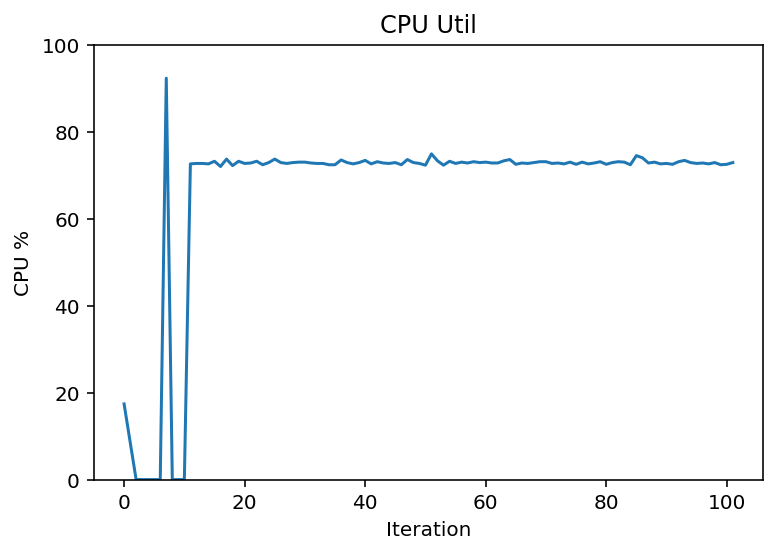

In [11]:
cpu_util = []

print("Measure overhead: ", end="")

st = time.time()
for i in range(1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()
overhead = et-st

print(overhead, "s")

time.sleep(2)

st = time.time()
for i in trange(ITERATIONS+1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()

duration = et-st-overhead
fps = int(BATCH_SIZE*ITERATIONS/duration)
print("Total time taken:", duration)
print("   Images/second:", fps)

x = list(range(len(cpu_util)))
plt.title("CPU Util")
plt.plot(x, cpu_util)
plt.xlabel("Iteration")
plt.ylabel("CPU %")
plt.ylim((0,100))
plt.show()

In [12]:
# clean-up
del dataset, train, read_example
time.sleep(1)
tf.keras.backend.clear_session()

## Compile Image Augmentation

In [13]:
dataset = dataloaders.return_fast_tfds(dataset_name="imagenet2012",
                                       data_dir="/raid/tensorflow_datasets",
                                       worker_threads=worker_threads,
                                       buffer=16384)
num_class = dataset["num_class"]

#optionals = tf.autograph.experimental.Feature.ALL
@tf.function(experimental_compile=True)
def read_example(image_path, label):
    image = tf.io.decode_jpeg(image_path, channels=3, ratio=1,
                              fancy_upscaling=False,
                              dct_method="INTEGER_FAST")
    image = ops.resize_preserve_ratio(image, L_IMG_SIZE)
    image = ops.augment_image(image, IMG_SIZE)
    return image, label

train = dataset["train"]
train = train.map(read_example, num_parallel_calls=worker_threads)
train = train.batch(BATCH_SIZE, drop_remainder=True)
train = train.prefetch(8)
train_iter = iter(train)

print("Running pipeline:")
batch = next(train_iter)
image, label = batch[0].numpy(), batch[1].numpy()
print("* Image shape:", image.shape)
print("* Label shape:", label.shape)

print("Wait for CPU idle")
while psutil.cpu_percent(interval=1.0) > 1/n_cores*100:
    time.sleep(1)
print("CPU:", psutil.cpu_percent(interval=None))
print("Done!")

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imagenet2012 (/raid/tensorflow_datasets/imagenet2012/5.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /raid/tensorflow_datasets/imagenet2012/5.0.0


Found 1000 classes in imagenet2012
Found training examples: 1281167
Found validation examples: 50000
Train output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Valid output: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>
Took 0 seconds to return dataset
Running pipeline:
* Image shape: (1024, 224, 224, 3)
* Label shape: (1024,)
Wait for CPU idle
CPU: 0.0
Done!


Measure overhead: 0.22064781188964844 s


100%|██████████| 101/101 [00:20<00:00,  4.99it/s]


Total time taken: 20.235968112945557
   Images/second: 5060


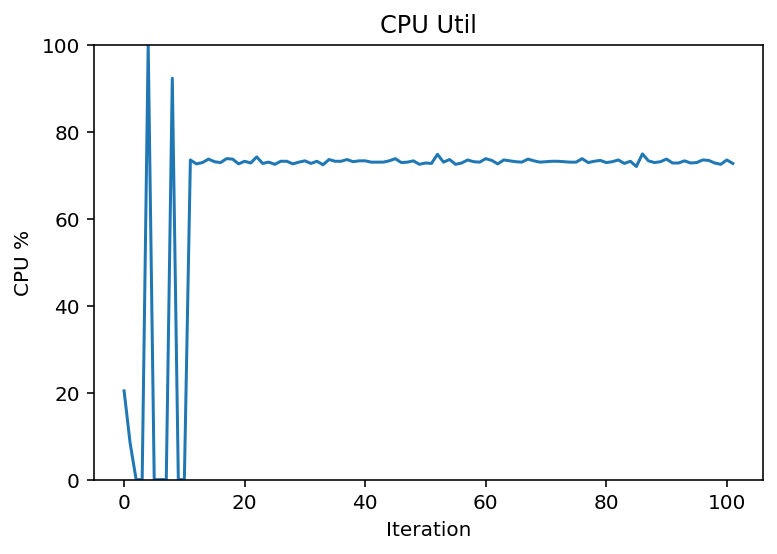

In [15]:
cpu_util = []

print("Measure overhead: ", end="")

st = time.time()
for i in range(1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()
overhead = et-st

print(overhead, "s")

time.sleep(2)

st = time.time()
for i in trange(ITERATIONS+1):
    batch = next(train_iter)
    image, label = batch[0], batch[1]
    cpu_util.append(psutil.cpu_percent(interval=None))
image, label = str(batch[0].numpy()), str(batch[1].numpy())
et = time.time()

duration = et-st-overhead
fps = int(BATCH_SIZE*ITERATIONS/duration)
print("Total time taken:", duration)
print("   Images/second:", fps)

x = list(range(len(cpu_util)))
plt.title("CPU Util")
plt.plot(x, cpu_util)
plt.xlabel("Iteration")
plt.ylabel("CPU %")
plt.ylim((0,100))
plt.show()